# AR Modeling for Cross-Time Prediction

In this Notebook is to be performed an AR(10) prediction. In high-level, we discern between 4 datasets.

- Channel True Dataset (Provided) 2 polarisations with **[Ncarriers x Nantennas x 590]**
- Channel Estimate Dataset (Generated) 2 polarisations with **[Ncarriers x Nantennas x 590]**
- MPC Dataset (Provided) 2 polarisations with **[(N_Multipath Components (Amplitude) + Phase)  x 590]**
- MPC Predicted Dataset (Generated) **[(N_Multipath Components (Amplitude) + Phase)  x 590]**

Library Loading

In [16]:
import numpy as np
import pandas as  pd
import tensorflow as tf
from tensorflow import keras
#import keras
import matplotlib.pyplot as plt 
from tensorflow.keras import layers
from sklearn import *
import math
from sklearn import linear_model as lm  # Used for solving linear regression problems
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
plt.rcParams["figure.figsize"] = (20,10)
tf.autograph.set_verbosity(0)
import scipy.io
from numpy.linalg import norm 
import cmath
import math

Import functions from ./Utilities AR file in this same folder, look for comments on the functions in that notebook

In [17]:
from ipynb.fs.defs.UtilitiesAR import * 


## Import Data


Data Loading and variable generation

In [18]:
# Number of Multipath Components in the dataset (Number of Columns)

mpc = 640


In [19]:
# Number of Carriers and Antennas for Polarisations (Channel)

carriers = 408
antennas = 32

In [20]:
# Load the Data from in Polar form (Amplitude and Phase are separated)

# 1st Polarisation
data =  pd.read_csv("../../Baseline/PPCA/Baseline_UE1/Polar/UE1_data_unfold_arg_polar.csv", index_col=0)
# 2nd Polarisation
data2 =  pd.read_csv("../../Baseline/PPCA/Baseline_UE1/Polar/UE1_data_unfold_arg_polar_2.csv", index_col=0)

In [21]:
# This is the raw Multipath component data structure  in 3 dimensions from Matlab
# Multipath components
mat = scipy.io.loadmat("../../Data/data_UE1_600/quadriga_ue1_snr10_avg10TTI_total600TTI_evalinterval1TTI_seed123.mat")

# Parameter Matrix transformation to obtain the channel
G0 = mat['param'][0][0][0]

estimate_mpc = mat['param'][0][0][2]

# Real MPCs 1 Polarisation
estimate_mpc_1SB = mat['param'][0][0][2][0:mpc,0,:]

# Real MPCs 2 Polarisation
estimate_mpc_1SB_pol2 = mat['param'][0][0][2][mpc:,0,:]

Load the true channel Matrix

In [22]:
true_channel = scipy.io.loadmat('../../Data/data_UE1_600/channel_ue1.mat')


## True Channel Variables

In [23]:
# Subset 1st Subband and 1st Polarisation
True_channel_1SB = true_channel['channel_ue'][:antennas, :carriers, ].transpose()

# Subset 1st Subband and 2nd Polarisation
True_channel_1SB_pol2 = true_channel['channel_ue'][antennas:antennas*2, carriers:carriers*2, ].transpose()

# NMSE Estimated VS Real

In [24]:
# Estimate Channel 1st Polarisation
estimate_channel = estimate_mpc_1SB.T.dot(G0.T).reshape(590,carriers, antennas)
# Estimate Channel 2nd Polarisation
estimate_channel_pol2 = estimate_mpc_1SB_pol2.T.dot(G0.T).reshape(590,carriers, antennas)

In [25]:
# Subset of the true channel minus the first 10 samples (we just use 590 Samples) 1st polarisation
True_channel_1SB_11 = True_channel_1SB[10:,]

In [26]:
# Subset of the true channel minus the first 10 samples (we just use 590 Samples) 2nd polarisation
True_channel_1SB_pol2_1 = True_channel_1SB_pol2[10:,]

In [27]:
# Merging 2 Polarisations

# Channel Estimate
estimate_channel_both = np.concatenate([estimate_channel, estimate_channel_pol2], 2)
# Channel True
True_channel_both = np.concatenate([True_channel_1SB_11, True_channel_1SB_pol2_1], 2)

In [28]:
# NMSE Calculation over Time (Estimate VS True)
NMSE_TTI = [NMSE((True_channel_both[TTI,:,:]), (estimate_channel_both[TTI,:,:])) for TTI in range(estimate_channel_both.shape[0])] 

Text(0.5, 1.0, 'NMSE Real vs Estimate Channel UE1 2 Polarisations')

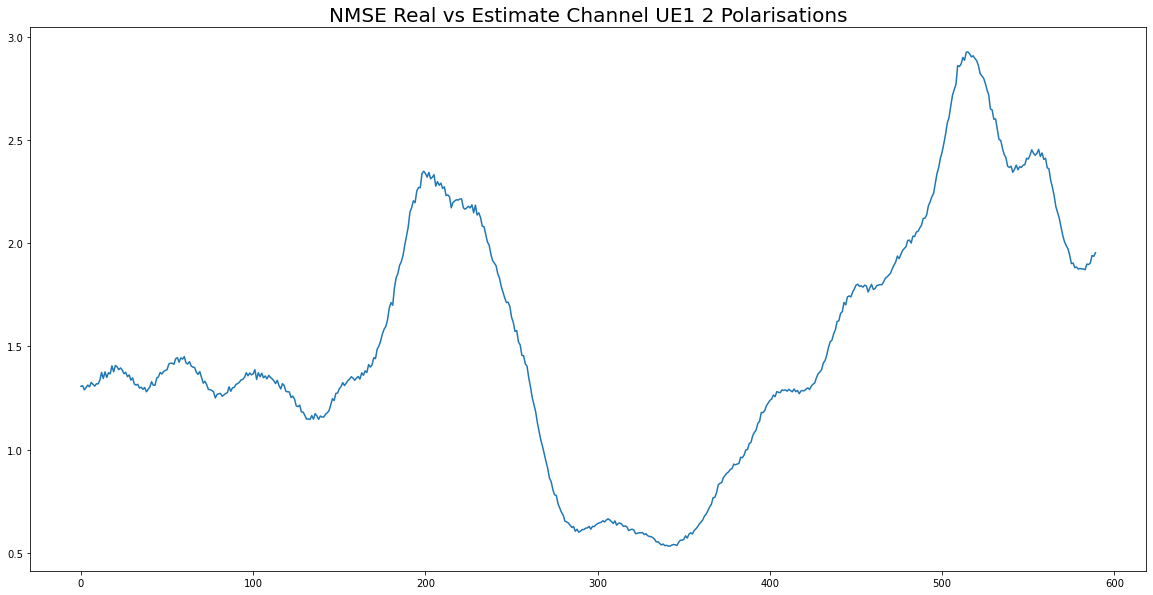

In [29]:
plot(NMSE_TTI)
plt.title('NMSE Real vs Estimate Channel UE1 2 Polarisations', size=20)


In [30]:
NMSE_TTI = [NMSE(np.angle(True_channel_1SB_11[TTI,:,:]), np.angle(estimate_channel[TTI,:,:])) for TTI in range(estimate_channel.shape[0])] 

Text(0.5, 1.0, 'NMSE Real vs Estimate Channel UE1 Polarisation 1 ')

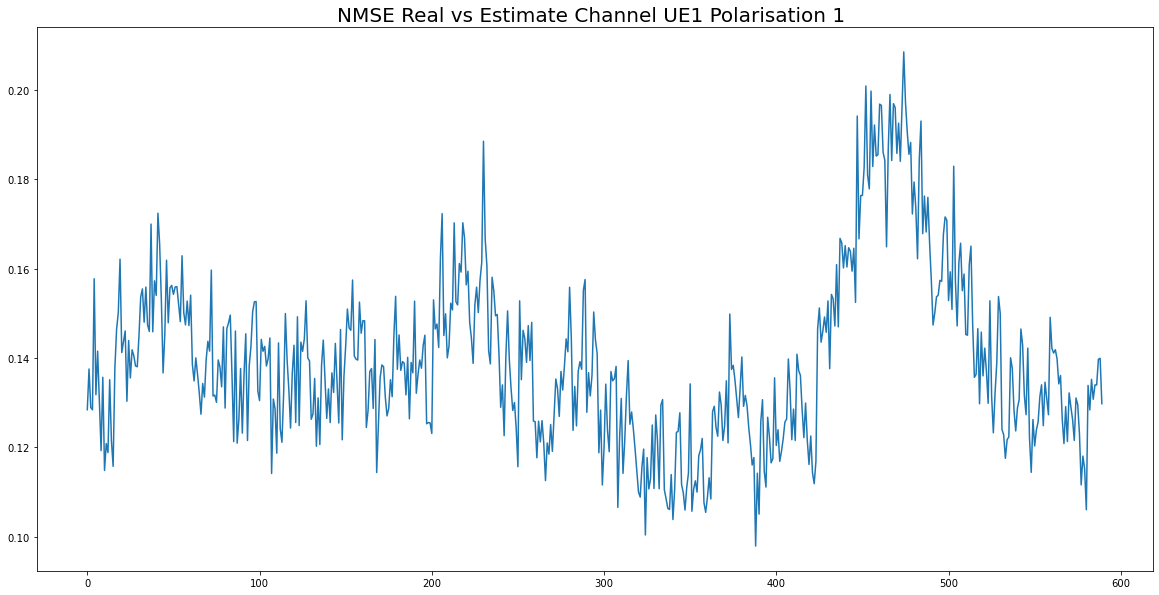

In [31]:
plot(NMSE_TTI)
plt.title('NMSE Real vs Estimate Channel UE1 Polarisation 1 ', size=20)


In [32]:
NMSE_TTI = [NMSE(np.angle(True_channel_1SB_pol2_1[TTI,:,:]), np.angle(estimate_channel_pol2[TTI,:,:])) for TTI in range(True_channel_1SB_pol2_1.shape[0])] 

Text(0.5, 1.0, 'NMSE Real vs Estimate Channel UE1 Polarisation 2')

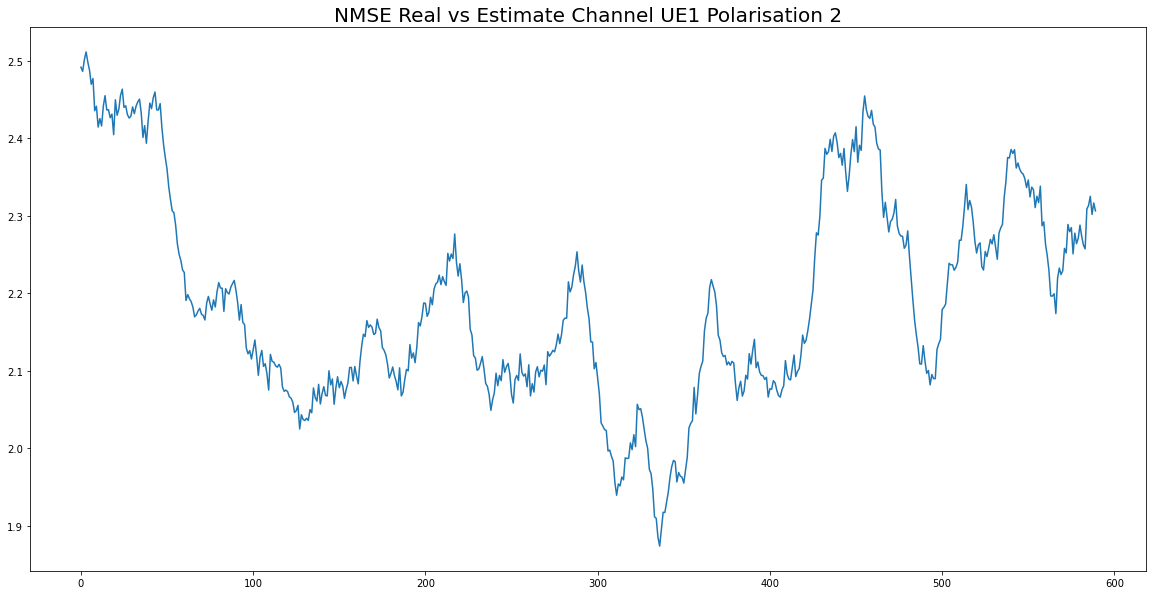

In [33]:
plot(NMSE_TTI)
plt.title('NMSE Real vs Estimate Channel UE1 Polarisation 2', size=20)


### Arrangement of 1 SB

Just Subsetting the 1st Multipath Component in the Multipath components Dataset

In [34]:
SB1 = data.iloc[:, :mpc*2]
mpc1 = SB1.iloc[:,0].to_numpy()

In [35]:
SB1_pol2 = data2.iloc[:, :mpc*2]
mpc1_pol2 = SB1_pol2.iloc[:,0].to_numpy()

This following cells are to detrend the path overtime **(For Visual Purposes)**. **For the prediction No Detrend Is Performed**

In [36]:
model = lm.LinearRegression().fit(X = np.arange(len(mpc1)).reshape(len(mpc1),1), y = mpc1)

model_pol2 = lm.LinearRegression().fit(X = np.arange(len(mpc1_pol2)).reshape(len(mpc1_pol2),1), y = mpc1_pol2)


In [37]:
predictions = model.predict(np.arange(len(mpc1)).reshape(len(mpc1),1))
predictions_pol2 = model_pol2.predict(np.arange(len(mpc1_pol2)).reshape(len(mpc1_pol2),1))


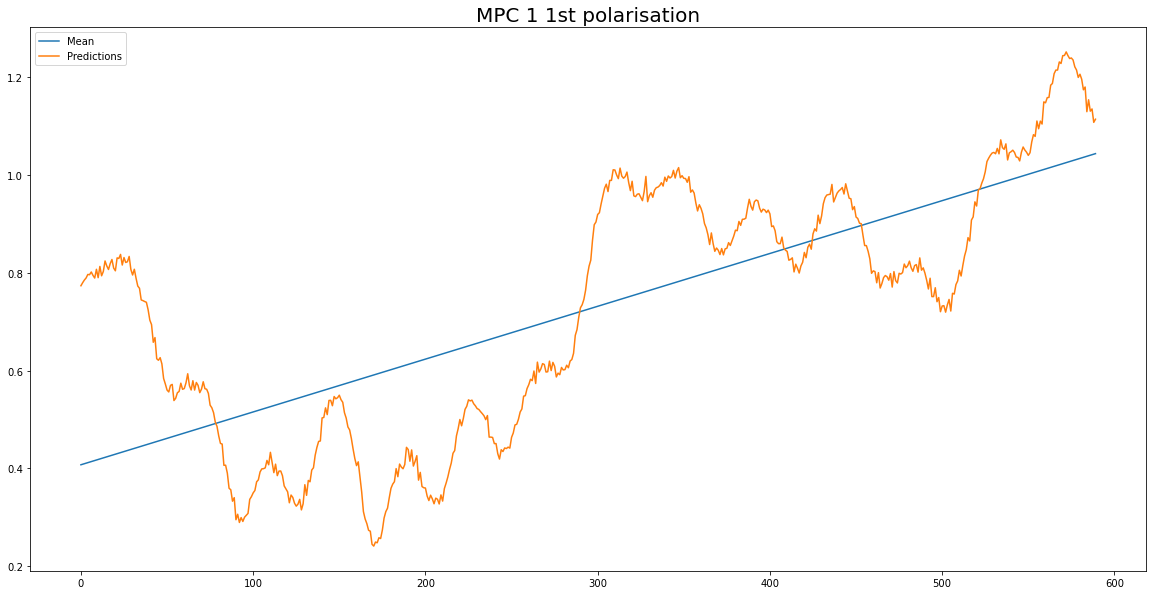

In [38]:
plt.plot(predictions, label="Mean")
plt.plot(mpc1, label="Predictions")
plt.title('MPC 1 1st polarisation', size=20)
plt.legend()
plt.show()

In [39]:
mpc1_no_mean = mpc1

In [40]:
#mpc1_no_mean = mpc1 - predictions

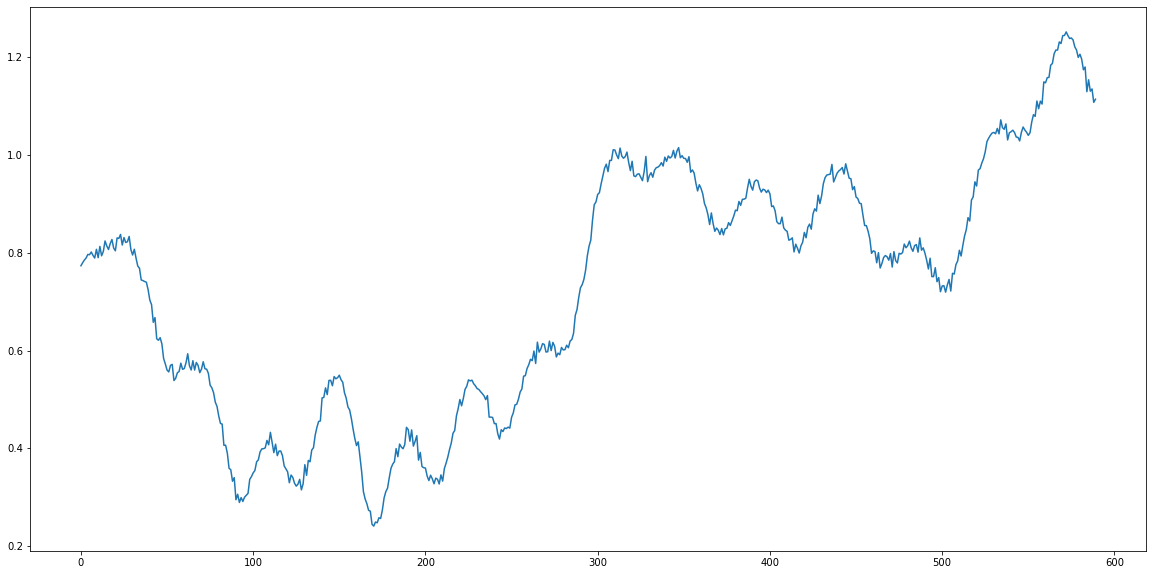

In [41]:
plot(mpc1_no_mean)


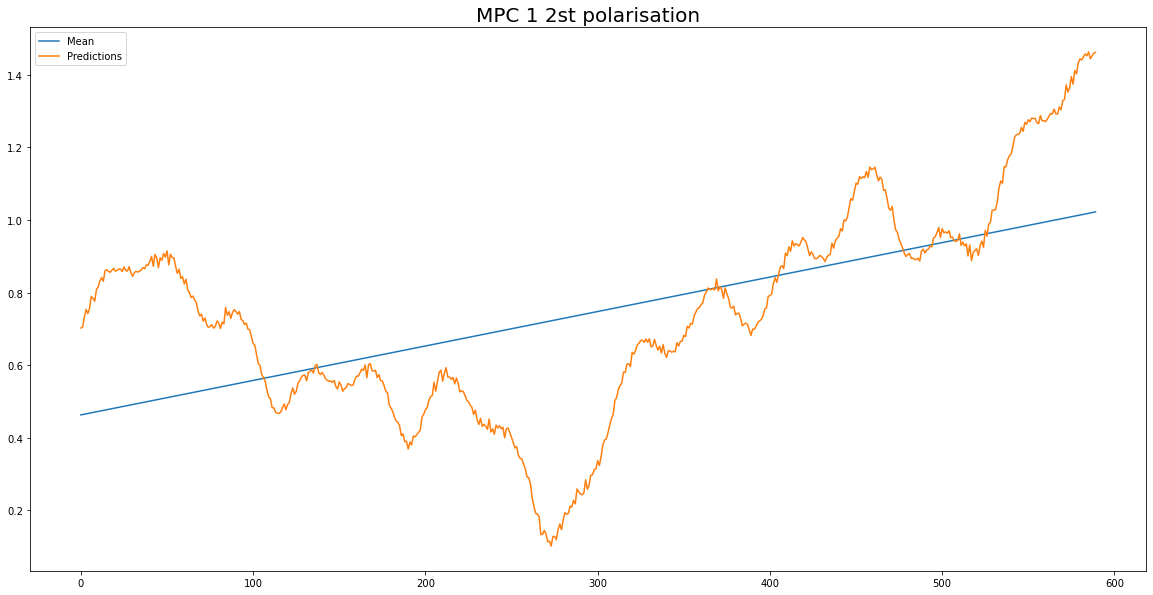

In [42]:
plt.plot(predictions_pol2, label="Mean")
plt.plot(mpc1_pol2, label="Predictions")
plt.title('MPC 1 2st polarisation', size=20)
plt.legend()
plt.show()

In [43]:
mpc1_no_mean_pol2 = mpc1_pol2

In [44]:
#mpc1_no_mean_pol2 = mpc1_pol2 - predictions_pol2

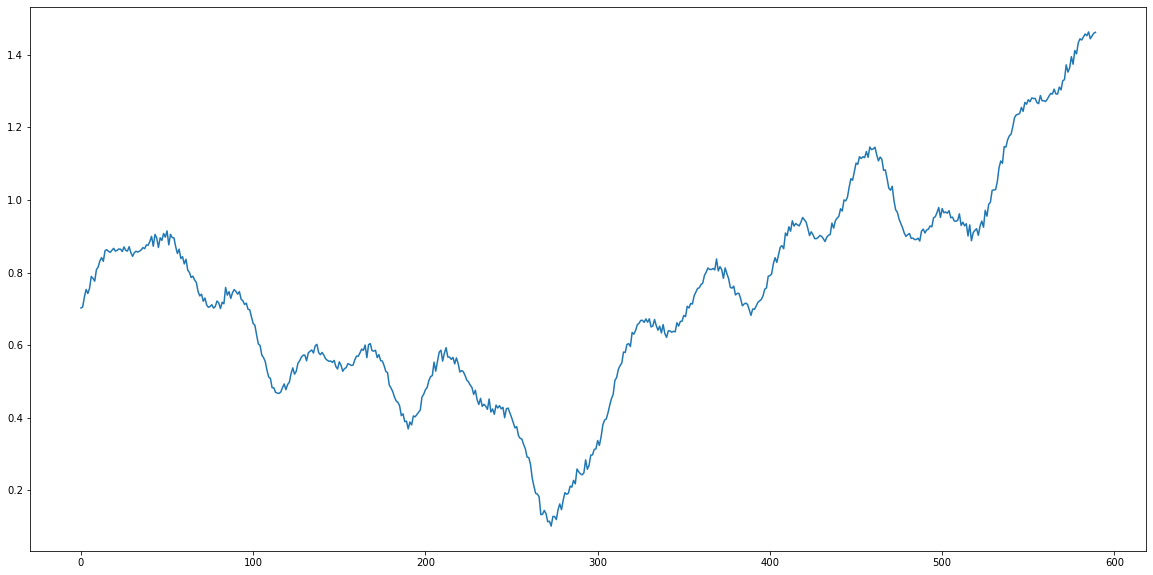

In [45]:
plot(mpc1_no_mean_pol2)


The following cell is to showcase the evolution of the 4 1st MPCs during time (Amplitude & Phase)

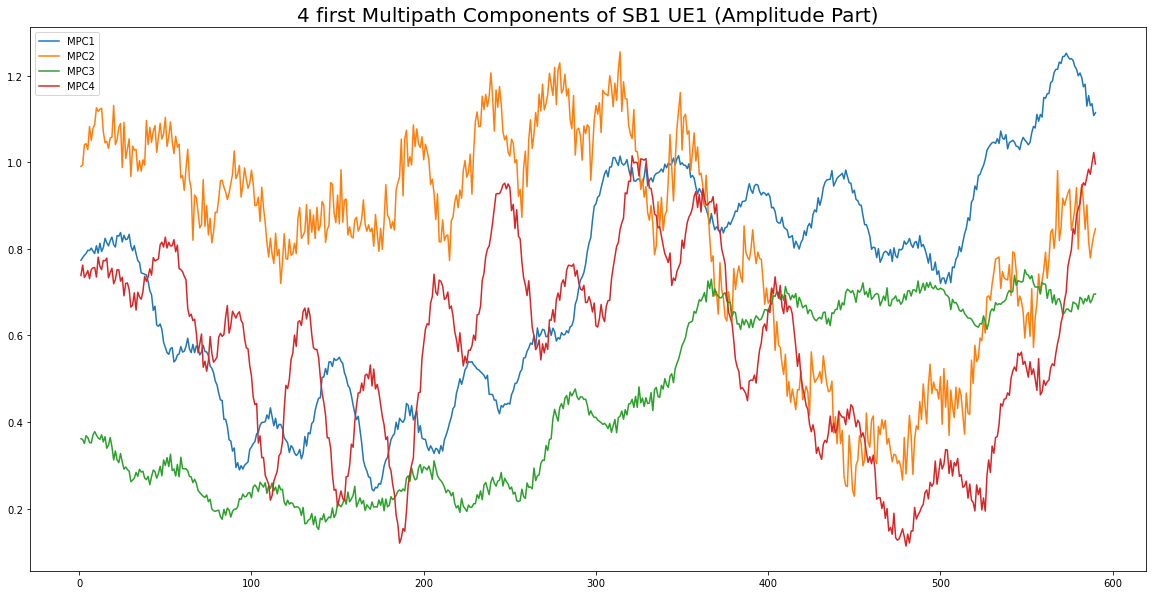

In [46]:
plot(SB1.iloc[:,0], label="MPC1")
plot(SB1.iloc[:,1], label="MPC2")
plot(SB1.iloc[:,3], label="MPC3")
plot(SB1.iloc[:,4], label="MPC4")
plt.legend()
plt.title("4 first Multipath Components of SB1 UE1 (Amplitude Part)", size=20)
plt.show()

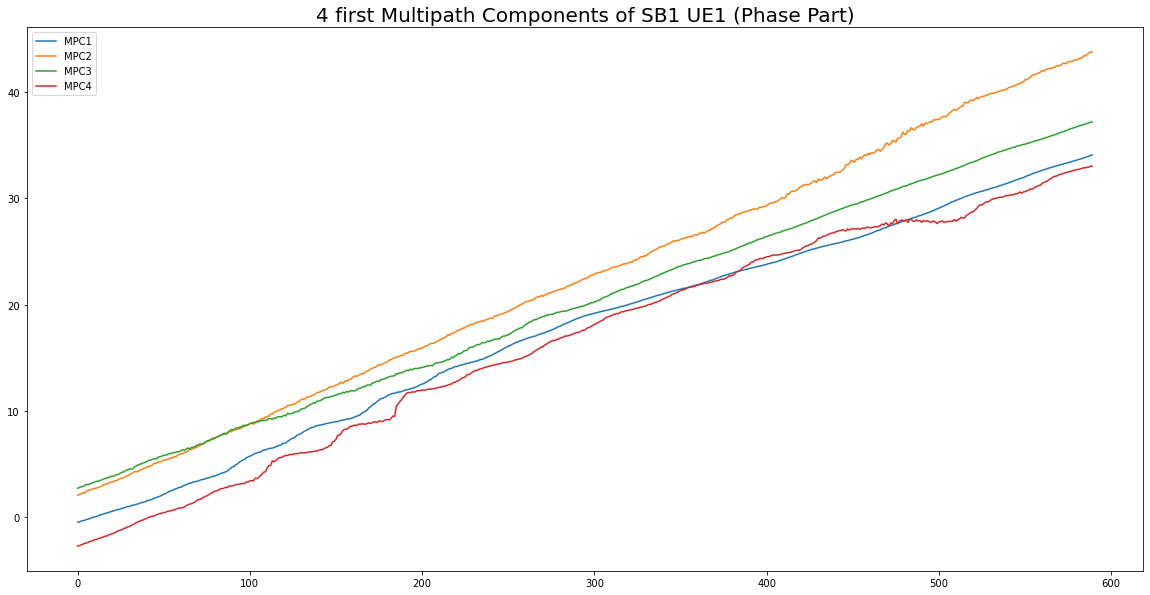

In [47]:
plot(np.unwrap(SB1.iloc[:,mpc+0]), label="MPC1")
plot(np.unwrap(SB1.iloc[:,mpc+1]), label="MPC2")
plot(np.unwrap(SB1.iloc[:,mpc+3]), label="MPC3")
plot(np.unwrap(SB1.iloc[:,mpc+4]), label="MPC4")
plt.legend()
plt.title("4 first Multipath Components of SB1 UE1 (Phase Part)", size=20)
plt.show()

## Modeling of 1st MPC

In this point we show how the prediction and fit of the model looks for 1 Path

In [48]:
# Training size to fit the Model Parameters
train_size = 50

In [49]:
train_pol1 = mpc1_no_mean[:train_size]
test_pol1 = mpc1_no_mean[train_size:len(mpc1_no_mean)]
print("train data samples: {0}, test data samples {1}".format(len(train_pol1), len(test_pol1)))

train data samples: 50, test data samples 540


In [50]:
train_pol2 = mpc1_no_mean_pol2[:train_size]
test_pol2 = mpc1_no_mean_pol2[train_size:len(mpc1_no_mean_pol2)]

Order of the AR Model

In [51]:
p=10

Fit the Model for the 1st MPC for 1st and 2nd Polarisations

In [52]:
train_pol1 = np.expand_dims(train_pol1, 1)

coef = fit_ar(train_pol1, p)


In [53]:
train_pol2 = np.expand_dims(train_pol2, 1)

coef_pol2 = fit_ar(train_pol2, p)

Prediction for the testing set

In [54]:
predictions_all_pol1 = predict_ar_1step(coef, mpc1_no_mean)

In [55]:
predictions_all_pol2 = predict_ar_1step(coef_pol2, mpc1_no_mean_pol2)

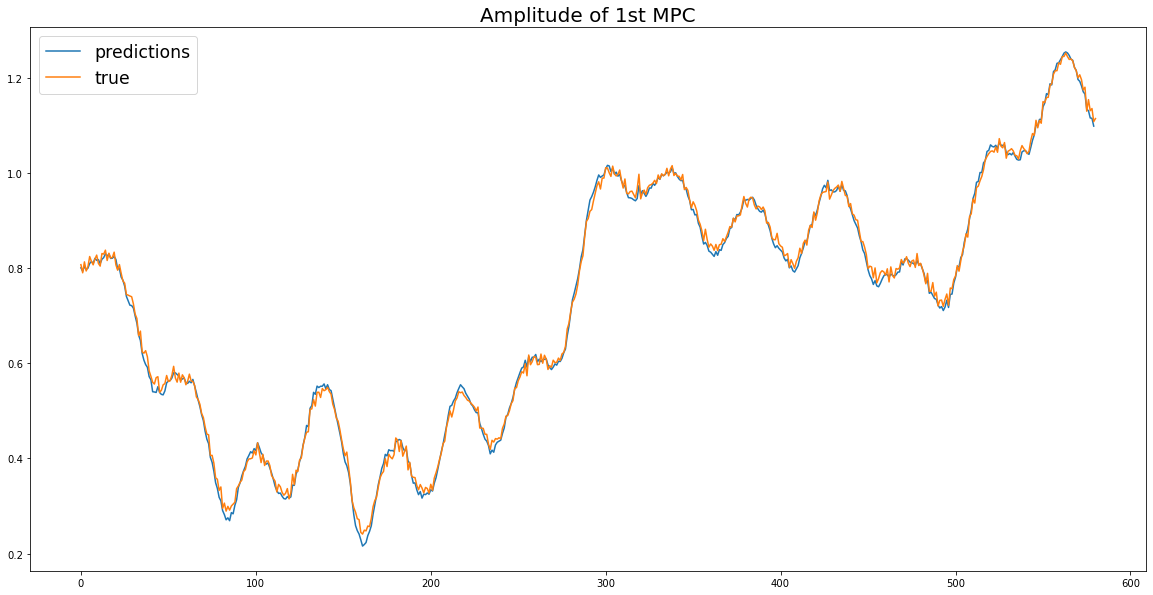

In [56]:
plt.plot(predictions_all_pol1[:-1], label = "predictions")
plt.plot(mpc1_no_mean[p-1:], label = "true")
plt.title('Amplitude of 1st MPC', fontsize=20)

plt.legend(fontsize='xx-large')
plt.show()

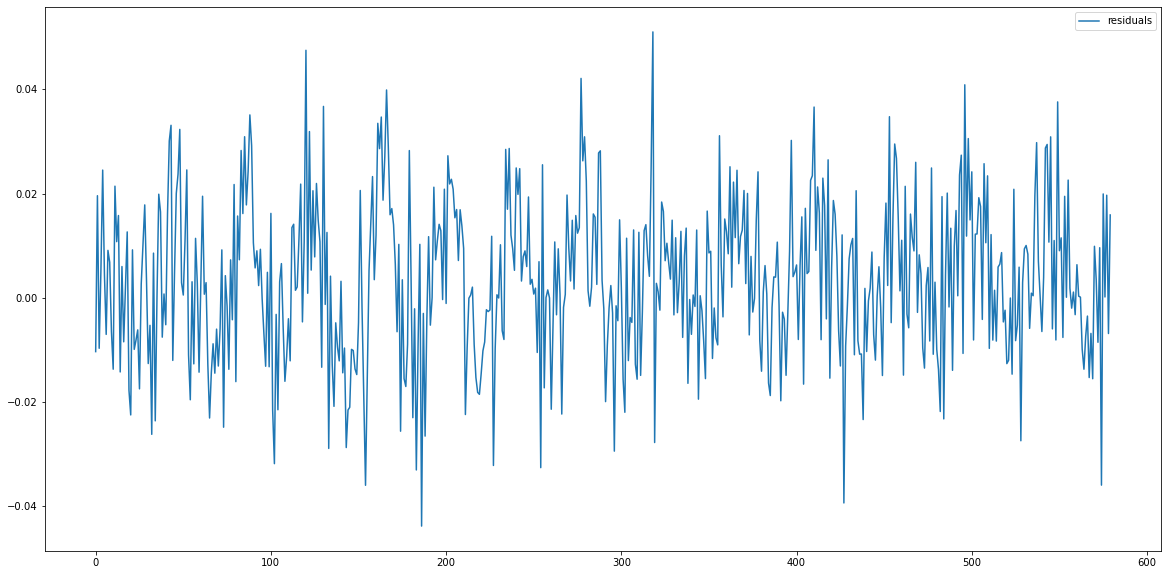

In [57]:
plt.plot(mpc1_no_mean[p:] - predictions_all_pol1[:-1], label = "residuals")
plt.legend()
plt.show()

Note that below this is the prediction for the 1st MPC in the 2nd polarisation. It is a bit less Accurate

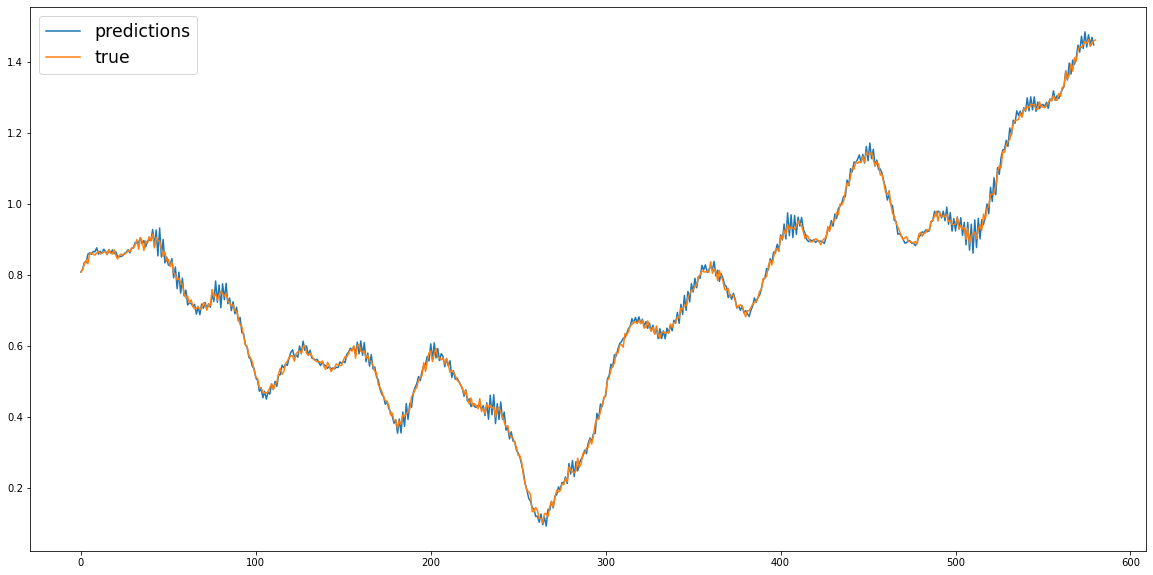

In [58]:
plt.plot(predictions_all_pol2[:-1], label = "predictions")
plt.plot(mpc1_no_mean_pol2[p-1:], label = "true")
plt.legend(fontsize='xx-large')
plt.show()

### Arrangement and prediction of Another less powerful MPC (300th)

In [59]:
nmpc=300

This following cells are to detrend the path overtime **(For Visual Purposes)**. **For the prediction No Detrend Is Performed**

In [60]:

mpc1 = SB1.iloc[:,nmpc].to_numpy()

In [61]:
model = lm.LinearRegression().fit(X = np.arange(len(mpc1)).reshape(len(mpc1),1), y = mpc1)


In [62]:
predictions = model.predict(np.arange(len(mpc1)).reshape(len(mpc1),1))


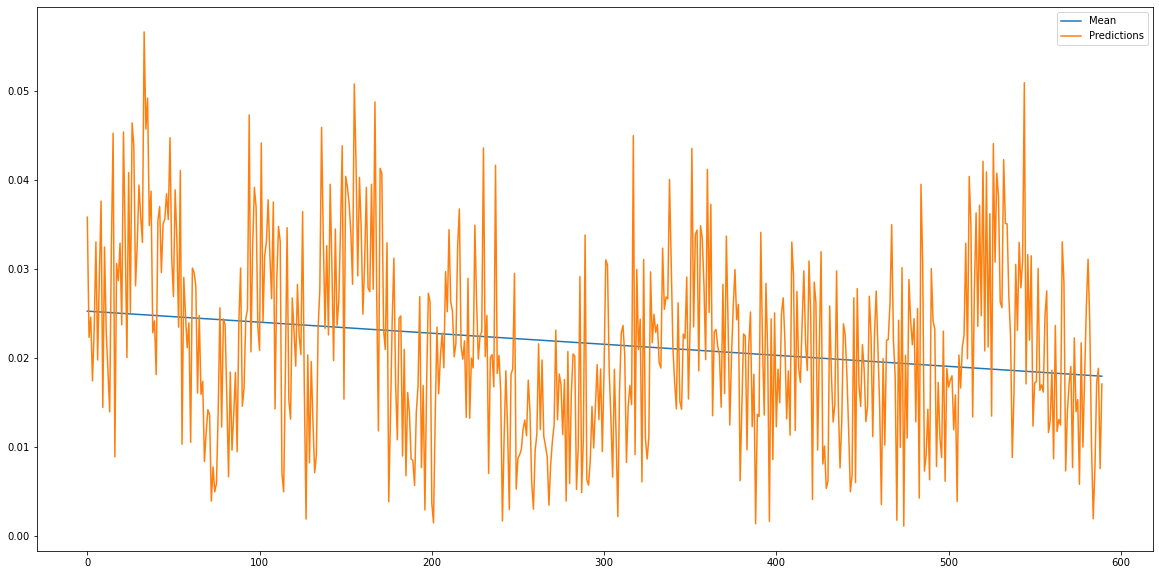

In [63]:
plt.plot(predictions, label="Mean")
plt.plot(mpc1, label="Predictions")
plt.legend()
plt.show()

In [64]:
data_no_mean = mpc1

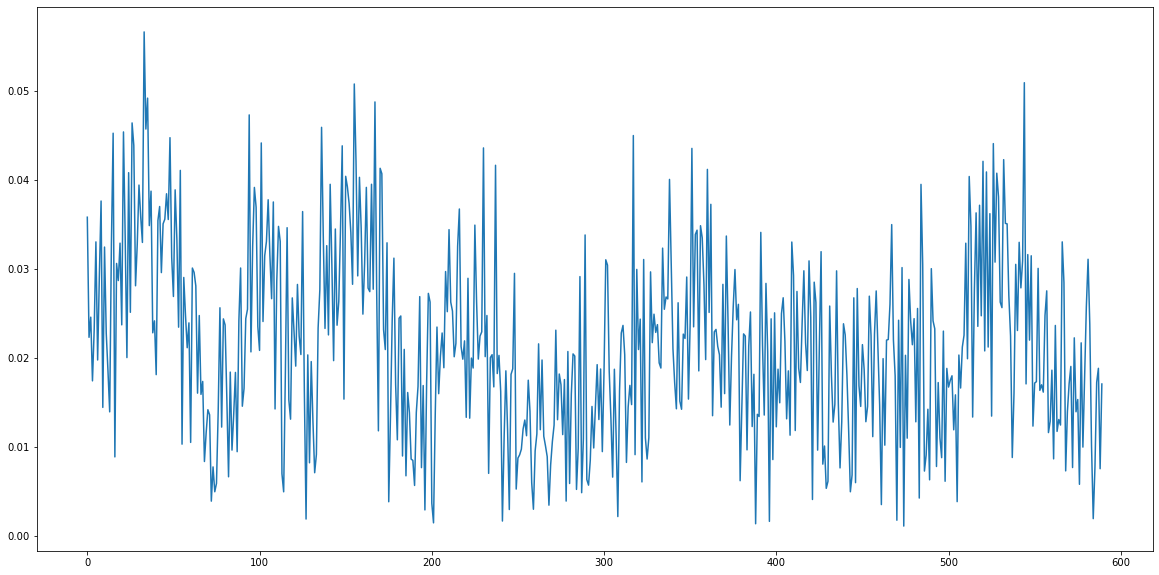

In [65]:
plot(data_no_mean)


In [66]:
train_size = 50

In [67]:
train = data_no_mean[:train_size]
test = data_no_mean[train_size:len(data_no_mean)]
print("train data samples: {0}, test data samples {1}".format(len(train), len(test)))

train data samples: 50, test data samples 540


In [68]:
train = np.expand_dims(train, 1)

coef = fit_ar(train, p)


In [69]:
predictions_all = predict_ar_1step(coef, data_no_mean)

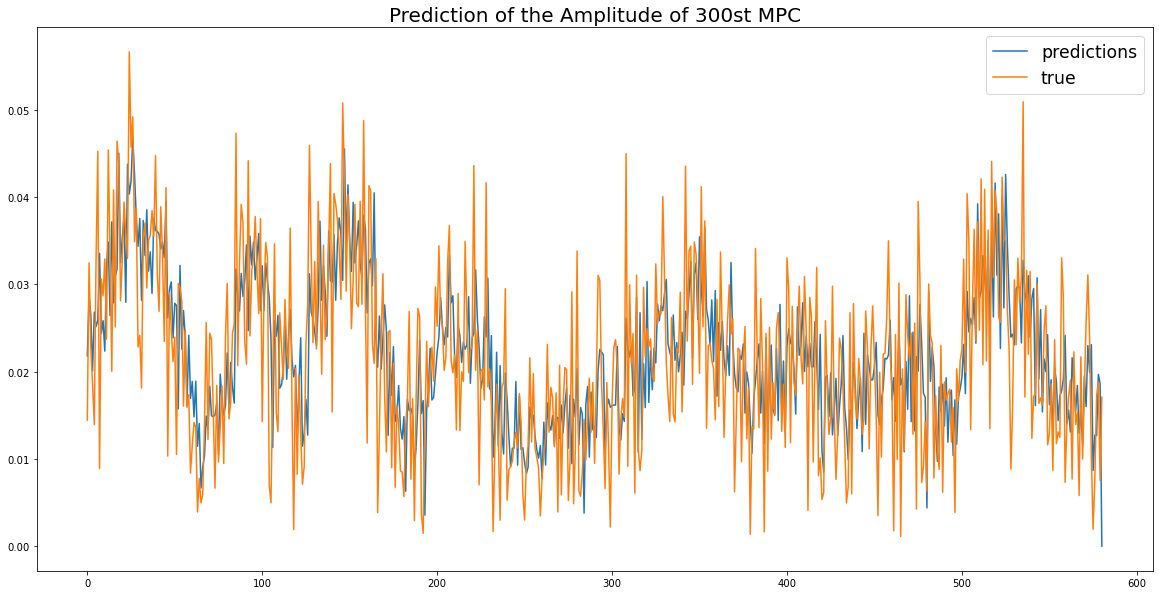

In [70]:
plt.plot(predictions_all, label = "predictions")
plt.plot(data_no_mean[p-1:], label = "true")
plt.legend(fontsize='xx-large')
plt.title("Prediction of the Amplitude of 300st MPC", fontsize=20)
plt.show()

## All SB prediction 

In [73]:
from scipy import signal


In [74]:
mpc=640


Subset 1st Subband in the MPC Dataset

In [75]:
SB1_mod = SB1.iloc[:,:mpc]

SB1_pha = SB1.iloc[:, mpc:mpc*2]
SB1_pha = SB1_pha.apply(np.unwrap)


In [76]:
SB1_mod_pol2 = SB1_pol2.iloc[:,:mpc]

SB1_pha_pol2 = SB1_pol2.iloc[:, mpc:mpc*2]
SB1_pha_pol2 = SB1_pha_pol2.apply(np.unwrap)


## Training

### Prediction in Amplitudes

In [77]:
# Optimize the parameters for every path (amplitudes and phase), we end up with 604x2 models - 1st Polarisation
coef = [fit_ar(np.expand_dims((SB1_mod[x].values), 1), 10) for x in SB1_mod.iloc[:train_size,]]

In [78]:
# Optimize the parameters for every path (amplitudes and phase), we end up with 604x2 models - 2nd Polarisation
coef_pol2 = [fit_ar(np.expand_dims((SB1_mod_pol2[x].values), 1), 10) for x in SB1_mod_pol2.iloc[:train_size,]]

#### Predictions Amplitudes Polarization 1

In [79]:
# Predict taking profit of the models  fit, 1 step ahead prediction- 1st polarisation
predictions_all = [predict_ar_1step(coeff, SB1_mod[MPC].values) for coeff, MPC in zip(coef, SB1_mod)]

#### Predictions Amplitudes Polarization 2

In [80]:
# Predict taking profit of the models  fit, 1 step ahead prediction- 2nd polarisation
predictions_all_pol2 = [predict_ar_1step(coeff, SB1_mod_pol2[MPC].values) for coeff, MPC in zip(coef_pol2, SB1_mod_pol2)]

### Prediction in Phase

Analogue to the previous cells but for the Phases

In [81]:
coef = [fit_ar(np.expand_dims((SB1_pha[x].values), 1), 10) for x in SB1_pha.iloc[:train_size,]]

In [82]:
coef_pol2 = [fit_ar(np.expand_dims((SB1_pha_pol2[x].values), 1), 10) for x in SB1_pha_pol2.iloc[:train_size,]]

#### Predictions Polarization 1 Phase 

In [83]:
predictions_all_pha = [predict_ar_1step(coeff, SB1_pha[MPC].values) for coeff, MPC in zip(coef, SB1_pha)]

#### Predictions Polarization 2 Phase

In [84]:
predictions_all_pha_pol2 = [predict_ar_1step(coeff, SB1_pha_pol2[MPC].values) for coeff, MPC in zip(coef_pol2, SB1_pha_pol2)]

### Fold Dataframe

#### Polarization 1 Folded Dataframe Amplitude-Phase (Prediction)

This is to merge the predictions of the Amplitudes and the Phases

In [85]:

SB1_pred = pd.concat([pd.DataFrame(predictions_all).T, pd.DataFrame(predictions_all_pha).T], axis=1, 
          ignore_index=True)


In [86]:
SB1_pred = SB1_pred.iloc[:-1,]

#### Polarization 2 Folded Dataframe Amplitude-Phase (Prediction)

In [87]:

SB1_pred_pol2 = pd.concat([pd.DataFrame(predictions_all_pol2).T, pd.DataFrame(predictions_all_pha_pol2).T], axis=1, 
          ignore_index=True)


In [88]:
SB1_pred_pol2 = SB1_pred_pol2.iloc[:-1,]

This following cells are to merge the amplitudes and phases in Complex values

#### Polarization 1 Folded Dataframe Amplitude-Phase Binomial


In [89]:
predicts_1SB = pd.DataFrame(reIm2complex_sb(SB1_pred))

#### Polarization 2 Folded Dataframe Amplitude-Phase Binomial


In [90]:
predicts_1SB_pol2 = pd.DataFrame(reIm2complex_sb(SB1_pred_pol2))

In [91]:
N_TTIs_Pred = SB1_pred.shape[0]

In [93]:
idxplot = np.arange(len(SB1_pha.iloc[10:,0]))

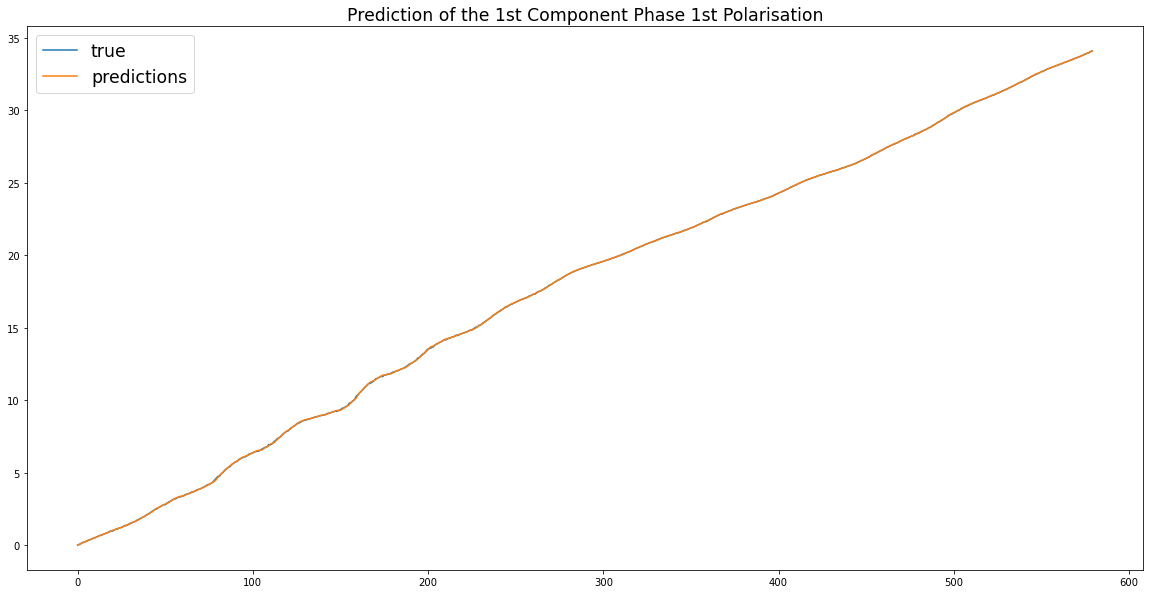

In [94]:
plot(idxplot, SB1_pha.iloc[10:,0], label = "true")
plot(idxplot, predictions_all_pha[0][:-1], label = "predictions")

plt.title("Prediction of the 1st Component Phase 1st Polarisation", fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.show()

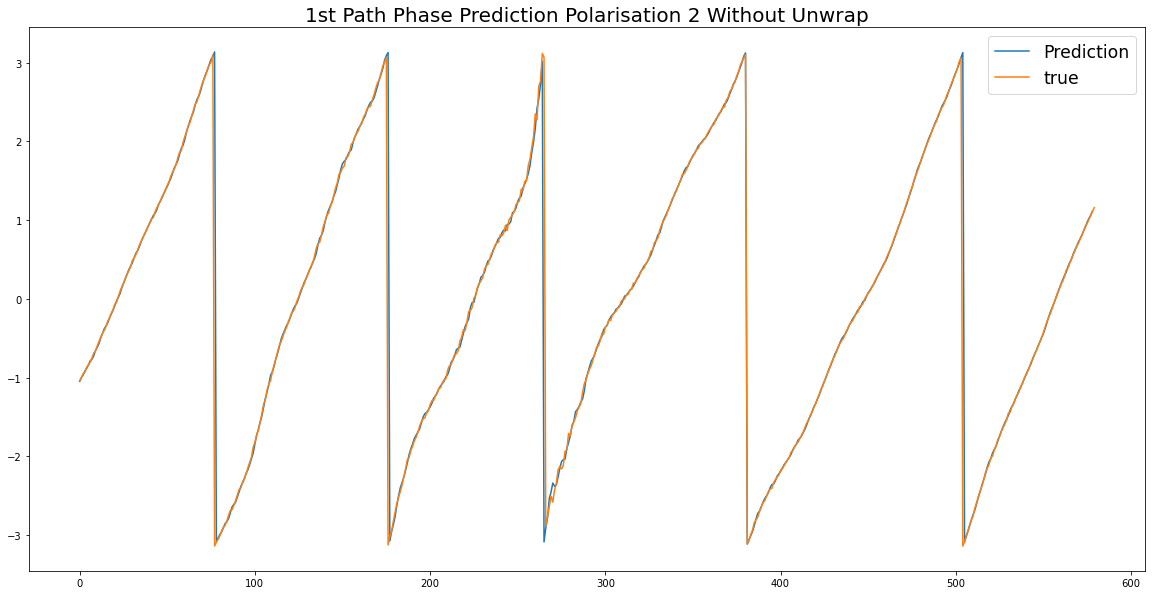

In [95]:
plot(np.angle(predicts_1SB_pol2[0][:-1]), label = "Prediction")
plot(wrap(SB1_pha_pol2).values[10:, 0], label = "true")
plt.title('1st Path Phase Prediction Polarisation 2 Without Unwrap', fontsize=20)
plt.legend(fontsize='xx-large')
plt.show()

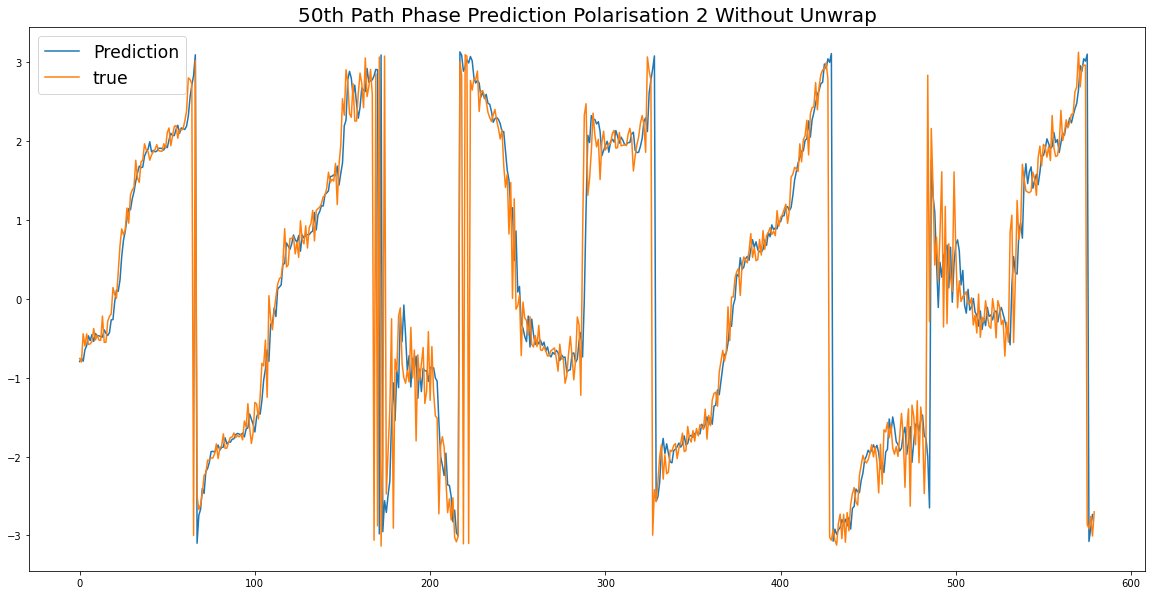

In [96]:
plot(np.angle(predicts_1SB_pol2[50][:-1]), label = "Prediction")
plot(wrap(SB1_pha_pol2).values[10:, 50], label = "true")
plt.title('50th Path Phase Prediction Polarisation 2 Without Unwrap', fontsize=20)
plt.legend(fontsize='xx-large')
plt.show()

## Transformation to Channel and NMSE Calculation

### 2 Polarizations Predicted Multipath components - Conversion to Channel

Here we transform the TTIs of the predicted Multipath Components to Channel (For every TTI) 

In [92]:
pred_channel = predicts_1SB.values.dot(G0.T).reshape(N_TTIs_Pred,carriers, antennas)
pred_channel_pol2 = predicts_1SB_pol2.values.dot(G0.T).reshape(N_TTIs_Pred,carriers, antennas)

Concatenate both polarisations of the predicted channels

In [90]:
pred_channel_both = np.concatenate([pred_channel, pred_channel_pol2], 2)


## True Channel 

In [91]:
True_channel_1SB__ = True_channel_1SB[10+p-1:-1,]
True_channel_1SB_pol2_1__ = True_channel_1SB_pol2_1[p-1:-1,]

### NMSE Calculation

In [92]:
NMSE_TTI = [NMSE((True_channel_1SB__[TTI,:,:]), (pred_channel[TTI,:,:])) for TTI in range(pred_channel.shape[0])] 

Text(0.5, 1.0, 'NMSE Real vs Predicted Channel UE1 Polarisation 1')

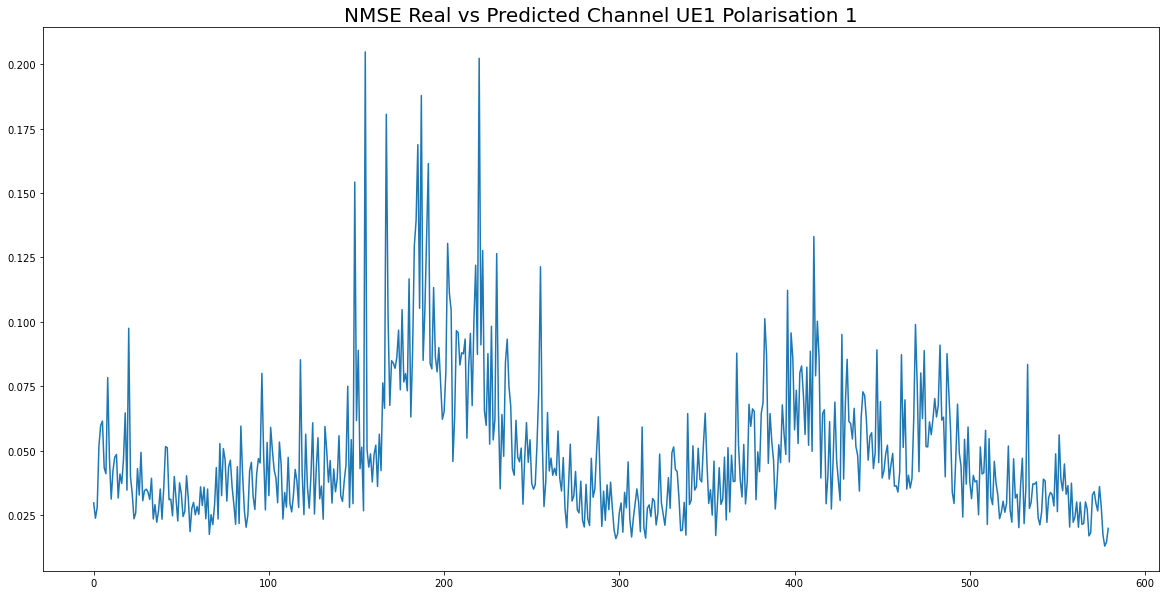

In [94]:
plot(NMSE_TTI)
plt.title('NMSE Real vs Predicted Channel UE1 Polarisation 1', size=20)


In [98]:
np.mean(NMSE_TTI)

0.049315806778084156

In [84]:
NMSE_TTI = [NMSE(abs(True_channel_1SB_pol2_1__[TTI,:,:]), abs(pred_channel_pol2[TTI,:,:])) for TTI in range(pred_channel_pol2.shape[0])] 

Text(0.5, 1.0, 'NMSE Real vs Predicted Channel UE1  Polarisation 2')

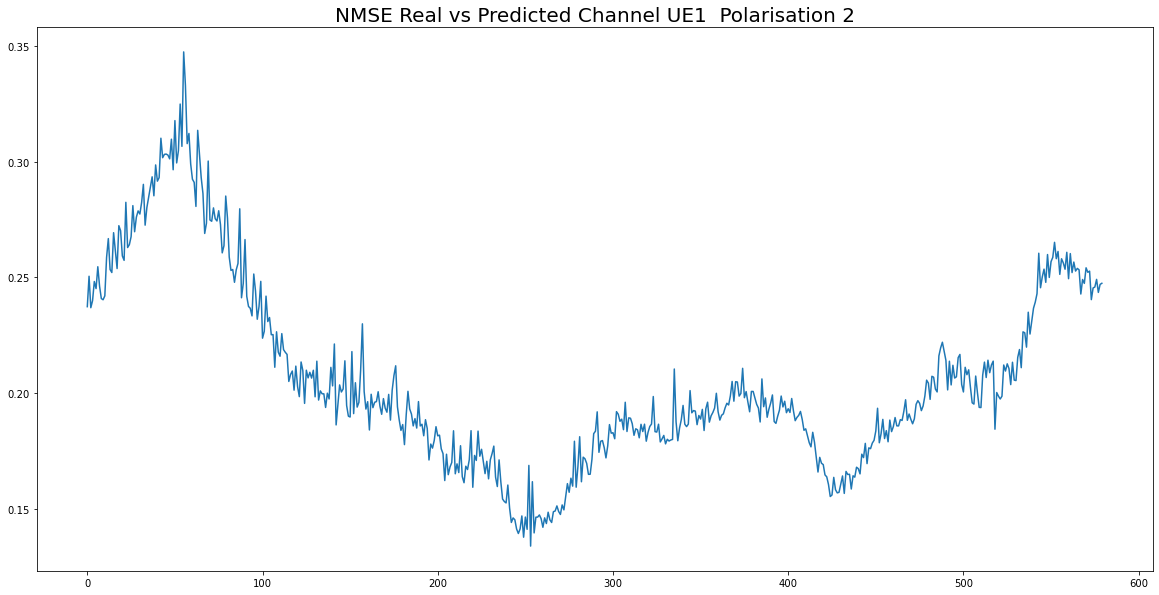

In [85]:
plot(NMSE_TTI)
plt.title('NMSE Real vs Predicted Channel UE1  Polarisation 2', size=20)


In [86]:
NMSE_TTI = [NMSE(True_channel_both[TTI,:,:], pred_channel_both[TTI,:,:]) for TTI in range(pred_channel_both.shape[0])] 

Text(0.5, 1.0, 'NMSE Real vs Predicted Channel UE1 2 Polarisations')

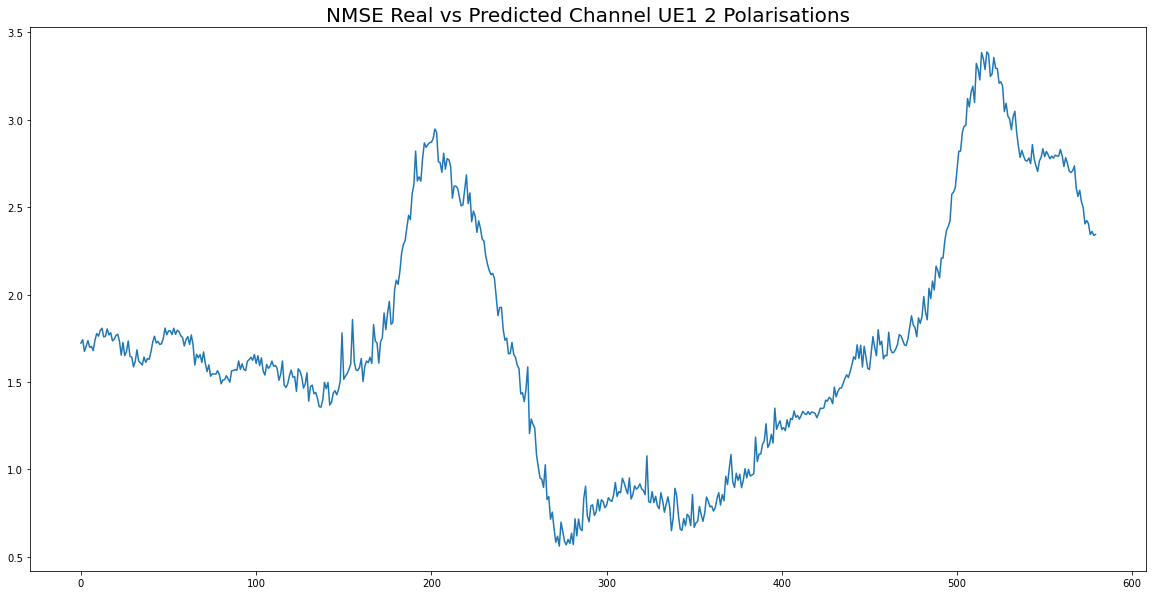

In [87]:
plot(NMSE_TTI)
plt.title('NMSE Real vs Predicted Channel UE1 2 Polarisations', size=20)
